# How much electric current would you need to use a railgun to launch a package up to the ISS?

A computational essay by Tor Ole Odden, postdoc at the University of Oslo's *Center for Computing in Science Education* 

Email: t.o.odden@fys.uio.no

## Introduction: What is a Railgun?

A railgun is a device that uses magnetic forces to accelerate a projectile to extremely high speeds. In the simplest case, it consists of two parallel, current-carrying rails (wires, essentially) with a moveable, conductive bar (the projectile launched by the railgun) between them. The bar, because it is a conductive, experiences a force due to the magenetic fields of the rails, which accelerates it.

The United States navy has recently debuted a 10-meter long railgun that can launch a 3.2 kg projectile at speeds up to 2500 m/s. Railguns are exciting, because theoretically they could represent a viable alternative to expensive chemical propulsion methods. While there are certainly many military applications to this type of system, one might also be able to use it for scientific purposes, such as launching satellites and supplies into orbit without the need for expensive, one-time-use rockets. However, how viable are railguns for these types of applications?

In this notebook, we aim to estimate how much current one would need in order to use such a railgun to launch a 1kg package of supplies to the ISS, which is approximately 405 km above the surface of the earth. We will create a simple simulation of this system, then add in some complicating factors to try to get a more accurate calculation.

![RailgunPic.jpg](images/RailgunPic.jpg)

The US Navy's Electromagnetic Railgun
(From [popular mechanics](https://www.popularmechanics.com/military/research/a14106941/us-navy-railgun-may-be-dead/))

## Initial Simulation of the Railgun

First, we have to import our various libraries. We will be using sympy and numpy for the graphing, as well as matplotlib. We'll also call the "notebook magic" command to make the plots show without needing to use extra commands every time.

In [1]:
%matplotlib inline 

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

Next, we define some parameters, including the current in the rails, the separation of the rails (which is also the width of the projectile), the lengths of the rails, and the mass of the projectile.

Using the [approximate dimensions](https://ndiastorage.blob.core.usgovcloudapi.net/ndia/2003/gun/ellis.pdf) of the navy railgun as a guide, we set the length of the rails to 10m and the separation of the rails to 15cm (corresponding to a 150mm bore railgun). We will also define the mass of the projectile (1 kg) and the magnetic constant for use in magnetic force calculations later on. And, we will define our timestep and initialize our time constant.

In [2]:
D = .15 #separation of the rails and width of the bar. Set to 15cm
w = 0.1 #width of the rails. Set to 10cm each
L = 10 #length of the rails. Set to 10m
m = 1 #set mass to 1kg
I = 10000 #starting current. Set to 10000 Amps

dt=.00001 #initial timestep 0.00001s
t=0 #time starts at 0

![Railgun_Diagram.jpg](images/Railgun_Diagram.jpg)

Now, we will need a way to calculate the force on the bar/projectile. This will require some derivation.

## Calculating the force on the bar

Assuming the rails are long, we can treat them as essentially infinite wires, in which case the magnitudes of their magnetic fields can be expressed as $$B_{rail} = \frac{\mu_0}{2 \pi}\frac{I}{r}$$

Cutting the bar between the rails into little slices of length $dr$, with current $I$ running through the entire system, we can express the magnitude of magnetic force on one small part of the bar, $\lvert dF_{B}\lvert$, as $$ dF_{B}= IdrB $$

(Here I'm ignoring the vector notation, noting that both of the rails will contribute forces on the bar in the same direction)

Now, we can combine these two expressions and integrate across the length of the bar. We will assume, as mentioned above, that each rail has width w, the bar has width D, and the current is running down the middle of the rail. Then, the force on the bar due to _one_ rail will be

$$\frac{\mu_0}{2 \pi}I^2 \int_{\frac{w}{2}}^{D+\frac{w}{2}} \frac{1}{r}dr$$ $$=\frac{\mu_0}{2 \pi}I^2 \big(\ln(D+\frac{w}{2})-\ln(\frac{w}{2})\big)$$

This gets us the force due to one rail. However, both rails are contributing the same force on the bar, doubling this force and leaving us with the final expression

$$F_{B}=2\frac{\mu_0}{2 \pi}I^2 \big(\ln(D+\frac{w}{2})-\ln(\frac{w}{2})\big)$$




Also note that based on this derivation, it appears that we will frequently be using the constant $\frac{\mu_0}{2 \pi}$. So, let's also define that.

In [3]:
Muover2pi = 2e-7 #magnetic constant

Now, let's put it all together and use the program to calculate the velocity of the bar under the simplest possible condition: a frictionless environment with infinite conducting rails (i.e., ignoring edge effects when the bar approaches the ends of the rails) and ignoring any other factors that might slow down the rail. This will be our best-case scenario.

We create a function that will run the railgun simulation. It will contain a loop that repeatedly calculates the magnetic force on the bar based on the above derivation, and uses that force to update the velocity of the bar. We'll have it return the final velocity, as well as arrays for position and time (for plotting).

In [4]:
#Arguments:
# L: Length of railgun
# w: width of rails
# D: width of the projectile
# v_0: initial velocity
# I: current in the railgun
# dt: timestep

def railgun(L,D,w,I,dt):
    posarray = np.zeros(0)
    timearray = np.zeros(0)
    v = 0
    barpos = 0
    t = 0
    
    while barpos < L:
        Fnet = 2*Muover2pi*(I**2)*(np.log(D+w/2)- np.log(w/2)) #net force, based on the above-derived expression
        v = v + Fnet/m*dt #Update the velocity of the bar
        barpos = barpos + v*dt #Use velocity to update position
        t = t+dt
        posarray = np.append(posarray,barpos)
        timearray = np.append(timearray,t)
    return v, posarray, timearray

v_test, pos, time = railgun(L,D,w,I,dt) #run a test instance of the railgun function
print(v_test)

33.30211766054752


It appears that a current of 10000 amps will give us a velocity of ~33 m/s. However, to lob something up to the ISS, we need a velocity of at least **~2733 m/s** (based on a quick calculation of the potential energy required to ascend 405km above the earth's surface, ignoring air resistance). So, we're going to need a lot more current!

Just as a check, we'll plot the position of the bar as a function of time. Since this is a constant force, we expect the plot to look like an object under constant acceleration.

Text(0, 0.5, 'Position (m)')

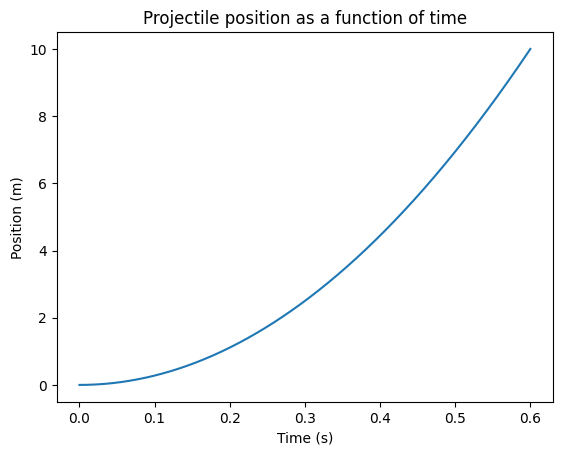

In [5]:
plt.plot(time,pos)
plt.title("Projectile position as a function of time")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")

Yup, that looks right!

## Finding the right current to launch a package up to the ISS

Now, our goal is to find the current required to launch a 1-kg package straight upwards to the ISS. Rather than doing this in a guess-and-check fashion, we'll do the loop multiple times see how high it has to go to reach the requisite velocity. This means we will have to define a new variable, the starting current. Since we have already seen that 10000 amps gives us a value several orders of magnitude below the required velocity, we will start an order of magnitude above, at 100,000 A, and begin the search there.

In [6]:
I_start = 100000 #Starting current. Set to 100,000 Amps
I = I_start #Set the current to this starting value

v_goal = 2733 #The final velocity we're aiming to achieve
v_test = 0

For a velocity of 2743.527458597128 m/s you need a current of 824387.2036334316 amps. Projectile takes 0.00728 seconds to exit barrel.


Text(0, 0.5, 'Position (m)')

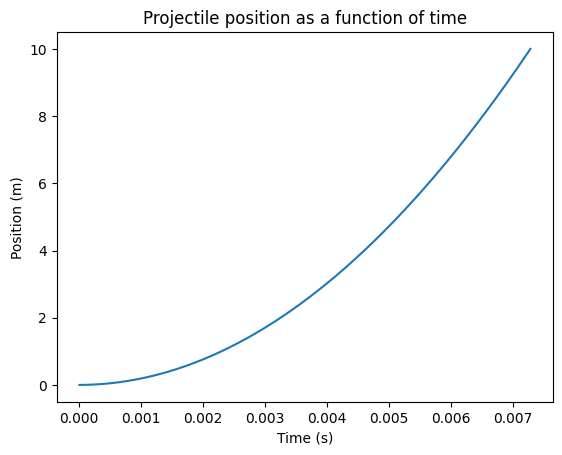

In [7]:
while v_test <= v_goal:
    v_test, pos, time = railgun(L,D,w,I,dt)
    I = I*1.01 #Increase the current by 1% each loop.
print("For a velocity of", v_test, "m/s you need a current of", I/1.01, "amps. Projectile takes", np.around(time[-1],decimals=5), "seconds to exit barrel.")

plt.plot(time,pos)
plt.title("Projectile position as a function of time")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")

So, based on these results, in an ideal, extremely simplified scenario we would need a little less than 825,000 Amps of current in order to launch 1kg up to the ISS (within a tolerance of 1%). The projectile takes about 0.0073 seconds to exit the barrel.

However, this is the most ideal scenario, ignoring many of the factors that would cost extra energy to overcome (for example: air resistance, electromagnetic induction, gravitational acceleration while the package is being launched, and the resistance/inductance of the rails). How do these factors change the amount of current required? 

## Adding some complicating factors: gravity and EM induction

Our first change is easy: add in the force of gravity during the launch (the time when the bar is actually touching the rails). To do this, we will add a factor of $ -9.8 m$ to the line of code where we calculate the net force. However, the launch window is so short that this is unlikely to make a significant difference to our final result.

More significant is the effect of electromagnetic induction on the system. In a system like this, we have a changing magentic flux through the loop created by the power supply, the rails, and the bar. This changing magnetic flux will create a current that will act to oppose (reduce) the current flowing through the system. How does that induced change our final velocity?

To add this into our simulation, we will first have to find an expression for the induced current in the system, which means finding an expression for the magnetic flux inside the loop created by the rails, power supply, and projectile. To do this, we can define the area of the loop as $D*x$ where $x$ is the distance that the bar has traveled along the rails so far. We will again assume that the magnetic field of the rails is given by

$$B_{rail} = \frac{\mu_0}{2 \pi}\frac{I}{r}$$

Integrating this across the length of the bar D, we get the following expression for the magnetic flux:

$$\Phi_{B}=2\frac{\mu_0}{2 \pi}I \big(\ln(D+\frac{w}{2})-\ln(\frac{w}{2})\big) x$$

Now, according to Lenz's law, the EMF around a closed loop is equal to the negative rate of change of the magnetic flux through the area enclosed by the loop:

$$ \varepsilon_{induced}=-\frac{d\Phi_{B}}{dt}$$

Assuming a low-to-negligible resistance, like 1$\Omega$ (a big assumption, but one we'll make here), this means

$$ I_{induced}=-\frac{d\Phi_{B}}{dt}$$

Taking the time derivative of the above expression for $\Phi_{B}$, we are left with

$$I_{induced}=-2\frac{\mu_0}{2 \pi}I \big(\ln(D+\frac{w}{2})-\ln(\frac{w}{2})\big)\frac{dx}{dt}$$
$$=-2\frac{\mu_0}{2 \pi}I \big(\ln(D+\frac{w}{2})-\ln(\frac{w}{2})\big)v$$ 

Where $v$ is the velocity of the bar.

Now, let's add these two expressions into our simulation. The gravity term will be subtracted off the net force, and the induced current term will be subtracted off our current within the loop.

In [8]:
def railgun_g_induct(L,D,w,I,dt):
    posarray = np.zeros(0)
    timearray = np.zeros(0)
    v = 0
    barpos = 0
    t = 0
    
    while barpos < L:
        I = I - 2*Muover2pi*I*(np.log(D+w/2)-np.log(w/2))*v #update the current, subtracting the induced current
        Fnet = 2*Muover2pi*(I**2)*(np.log(D+w/2)-np.log(w/2))-9.8*m
        v = v + Fnet/m*dt #Update the velocity of the bar
        barpos = barpos + v*dt #Use velocity to update position
        t = t+dt
        posarray = np.append(posarray,barpos)
        timearray = np.append(timearray,t)
    return v, posarray, timearray

In [9]:
I_start = 100000 #Starting current. Set to 100000 Amps
I = I_start #Set the current to this starting value
v_goal = 2733
v_test = 0

For a velocity of 2737.0122483673435 m/s you need a current of 1057220.5262223003 amps. Projectile takes 0.00622 seconds to exit the barrel.


Text(0, 0.5, 'Position (m)')

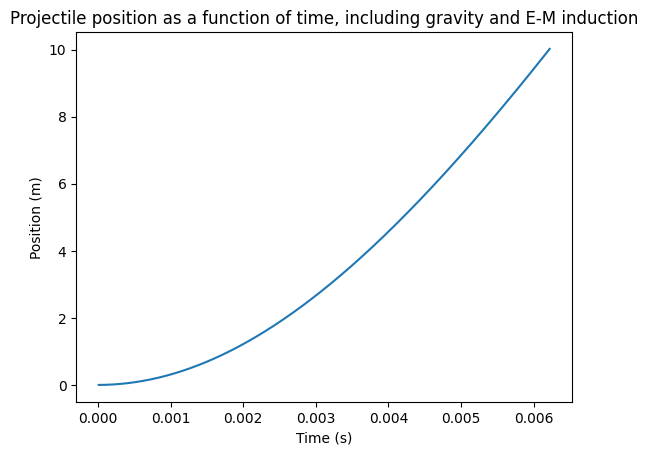

In [10]:
while v_test <= v_goal:
    I_start = I_start*1.01
    I = I_start
    v_test, pos_ind, time_ind = railgun_g_induct(L,D,w,I,dt)
print("For a velocity of", v_test, "m/s you need a current of", I, "amps. Projectile takes", np.around(time_ind[-1],decimals = 5), "seconds to exit the barrel.")

plt.plot(time_ind,pos_ind)
plt.title("Projectile position as a function of time, including gravity and E-M induction")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")

Our new current is approximately 1,060,000 amps, corresponding to an increase of about 28% above the calculated current without gravity and induction. While this current is necessary to achieve the desired velocity, it also contributes to a higher average velocity, shortening the length of time the projectile spends in the barrel of the railgun.

## Conclusion

Based on this extremely simplified model, it seems we would need a bit over a million amps of current in order to launch a 1kg package up to the ISS with a railgun. Note, however, that this is a very generous estimate; an actual system would also have to deal with complicating factors like
* Resistance of rails
* Inductance of rails
* Air drag after launch (assuming a vacuum inside launch tube)
* Power dissipation due to heat
* Friction between rails and bar
* Repulsion between the two rails

...not to mention the difficulty of launching the package close enough to the ISS to be picked up without hitting the station itself.

These additional factors are likely to make this form of orbital supply unfeasable for any reasonably-sized supply package (which is also likely be several tens of kilograms, minimum). For example, such high currents would likely cause the rails to strongly repel one another, potentially damaging the railgun after each launch.
